__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Lock, Manager, Pool, RawArray, Value, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots for Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options and constants__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# hit groups to skip
EXCEPT_GROUPS = ["Crosswalks", "End", "Events", "Sky", "Start"]

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CORES = cpu_count() - 1  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 11


__Helper functions__

In [3]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)


def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire,nulls_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,1.610
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.037
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,0.037
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,0.936
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,0.225
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,0.300
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,0.674
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,1.984


In [5]:
COL = "nulls_%"
parts[parts[COL] > 5].sort_values(by=[COL]).index.size

48

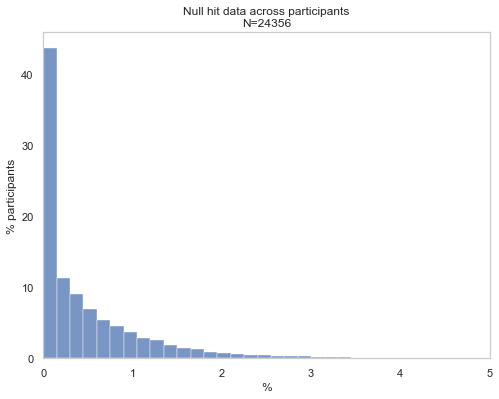

In [6]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.histplot(data=parts["nulls_%"], stat="percent", bins=100)

ax.set_xlim(0, 5)
ax.grid(False)
ax.set_xlabel("%")
ax.set_ylabel("% participants")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

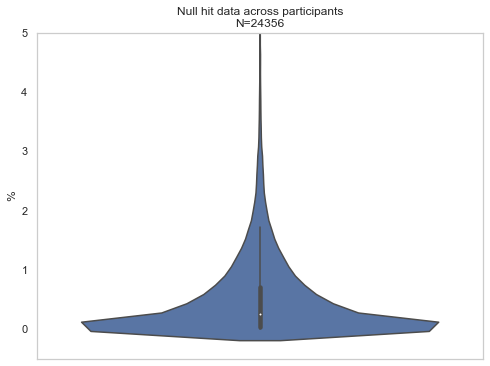

In [7]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.violinplot(data=parts["nulls_%"], stat="percent")

ax.set_ylim(-0.5, 5)
ax.grid(False)
ax.set_xticklabels([])
ax.set_ylabel("%")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

In [8]:
def correct_event_objects(uid):
    """
    Correct critical events (jogging, fast car, walking) object groups of a
    participant given its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    # read participant hit data
    p = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    # indices from critical event object names (if any)
    jogging = p["name"].str.contains(EV_0, regex=False, na=False)
    car_con = p["name"].str.contains(EV_1, regex=False, na=False)
    walking = p["name"].str.contains(EV_2, regex=False, na=False)
    ped_con = jogging | walking  # unify indices (pedestrian events)

    # select rows from whole hit data
    dudes = p[ped_con]
    car = p[car_con]
    changed = False  # to control if changes applied

    # if any row found for the events, apply changes
    if dudes.index.size > 0:
        dudes.group = "Dynamic Pedestrians"
        p[ped_con] = dudes
        changed = True
    if car.index.size > 0:
        car.group = "Dynamic Cars"
        p[car_con] = car
        changed = True

    # store into CSV only if changes were made
    if changed:
        p.to_csv(f"{PATH_PROC}/hits/{uid}.csv", index=False)


EV_0 = "Event 2.1 (2) Running"
EV_1 = "S_SUV03"
EV_2 = "event 2.2 walking"

# participants ids
uids = parts.index.tolist()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=correct_event_objects, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

__Collect and display all object groups across all participants__

In [9]:
def collect_groups(uid):
    """
    Collect all unique object groups given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    gs = cur.group.unique()
    for g in gs:
        if not pd.isnull(g):
            lock.acquire()
            if g not in groups:
                groups.append(g)
            lock.release()


manager = Manager()  # manage shared memory types

# convert into memory-shared dict of lists for multiprocessing
groups = manager.list()

# multiprocessing lock to avoid raicing conditions
l = Lock()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants uids to process
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_groups, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# cast proxy object to list (otherwise they can't be accessed)
groups = list(groups)
# sort list alphabetically
groups.sort()
display(groups)

📄 0 of 24356 📂 participants processed:                                                                        …

['Buildings',
 'Crosswalks',
 'Dynamic Cars',
 'Dynamic Pedestrians',
 'End',
 'Events',
 'Inside Car',
 'Nature',
 'Roads',
 'Sky',
 'Start',
 'Static Cars',
 'Static Pedestrians',
 'Street Objects',
 'Traffic Lights',
 'Traffic Signs']

__Collect and store all object unique groups and names across all participants__

In [11]:
def collect_names(uid):
    """
    Collect all unique object names given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")
    for grp in groups:
        names[uid][grp] = cur[cur.group == grp].name.unique()


def unique_names(grp):
    """
    Check all participants and get all unique object names given a group.
    Parameters:
        grp (str): Object group name.
    """
    for uid in uids:
        cum = list(unique[grp])
        cur = list(names[uid][grp])
        unique[grp] = list(set(cum + cur))


groups = [
    "Buildings",
    "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "End",
    "Events",
    "Inside Car",
    "Nature",
    "Roads",
    "Sky",
    "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

manager = Manager()  # manage shared memory types

# participants uids to process
uids = parts.index.tolist()

# uids progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 uids",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

gs = {grp: manager.list() for grp in groups}

# create memory-shared dict of lists for multiprocessing
names = manager.dict({uid: manager.dict(gs) for uid in uids_pbar})
unique = manager.dict({grp: manager.list() for grp in groups})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_names, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# After collecting them, get all unique names per group across participants
# TODO:
# - Find a way to see the progress while unifying the groups across parts

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# groups progress bar
groups_pbar = tqdm(
    iterable=pool.imap(func=unique_names, iterable=groups),
    total=len(groups),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in groups_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 uids processed:                                                                                …

📄 0 of 24356 📂 participants processed:                                                                        …

📄 0 of 16 📂 groups processed:                                                                                 …

Store them

In [12]:
# cast proxy object/s (otherwise they can't be accessed)
names = dict(unique)

with open(f"./groups_and_names.json", "w") as f:
    json.dump(names, f, indent=4)

Process all participants counting and groupping consecutive hitpoints

In [8]:
def nearest_hit(df):
    """
    Add description.

    Parameters:
        df (pd.DataFrame): Add desc.
    Returns:
        found (bool): Add desc.
        row (pd.Series): Add desc.
    """
    idxs = df.index.tolist()
    found = False
    for idx in idxs:
        c = df.loc[idx]
        row = c if c.group not in EXCEPT_GROUPS and c.group != "" else None
        found = not isinstance(row, type(None))
        if found:
            break
    return found, row


def collect_hit_events(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    # read current participant origins and hits datasets
    orgs = pd.read_csv(f"{PATH_PROC}/origins/{uid}.csv")
    orgs = orgs.set_index("frame")  # set frame column as index
    hits = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    frames = orgs.index.tolist()  # all frames (0-2670)

    # dict to collect gaze events info
    h_events = {
        "name": [],
        "group": [],
        "start": [],
        "end": [],
        "nHits": [],
        "distance": [],
        "length": [],
        "type": [],
    }

    # dict to check consecutives
    check = {"p": None, "start": None, "cnt": 0}
    dist = []
    for f in frames:  # for each frame
        cur = hits[hits.frame == f]
        # closest object hit if not in exceptions nor null, otherwise next
        found, cur = nearest_hit(cur)
        if found:
            d = float(cur.distance)
            name = cur["name"]  # .name calls .Name of the series!!
            group = cur.group
            if f < len(frames) - 1:
                fou, nex = nearest_hit(hits[hits.frame == f + 1])
                nex_name = nex["name"] if fou else None
                nex_grp = nex.group if fou else None
            else:
                nex_name = None
            if not check["p"]:  # not previous yet or ATM
                dist = []
                dist.append(d)
                check["p"] = name
                check["start"] = f
                check["cnt"] += 1
            else:
                dist.append(d)
                check["p"] = name
                check["cnt"] += 1
            if name != nex_name:
                d = sum(dist) / len(dist)
                d = round(d, 3)
                n_hits = check["cnt"]
                e_type = "gaze" if n_hits > 7 else "rest"
                h_events["name"].append(name)
                h_events["group"].append(group)
                h_events["start"].append(check["start"])
                h_events["end"].append(f)
                h_events["nHits"].append(n_hits)
                h_events["distance"].append(d)
                h_events["length"].append(n_hits * 0.033)
                h_events["type"].append(e_type)
                # reset
                check = {"p": None, "start": None, "cnt": 0}
                store = False

    h_events = pd.DataFrame(h_events)
    h_events.to_csv(f"{PATH_PROC}/gazes/{uid}.csv", index=False)


# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants ids
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=collect_hit_events, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

Find event frames

In [9]:
def event_frames(uid):
    """
    Collect event frames and object names of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    cond = h_events["name"].str.contains(EVE, regex=False, na=False)
    h_events = h_events[cond]
    hev_frames[uid] = h_events.start.tolist()


EVE = "event 2.2 walking"
    
# participants ids
uids = parts.index.tolist()

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_frames = manager.dict({uid: manager.list() for uid in uids})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=event_frames, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

In [10]:
test = dict(hev_frames)
test = {k: list(v) for k, v in test.items()}

In [11]:
with open("frames_events.json", "w") as outfile:
    json.dump(test, outfile)

In [12]:
with open("frames_events.json") as f:
    test = json.load(f)

In [17]:
for k in list(test.keys())[:1]:
    print(type(test[k]))

<class 'list'>


In [ ]:
"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""

📄 0 of 24356 📂 participants processed:                                                                        …

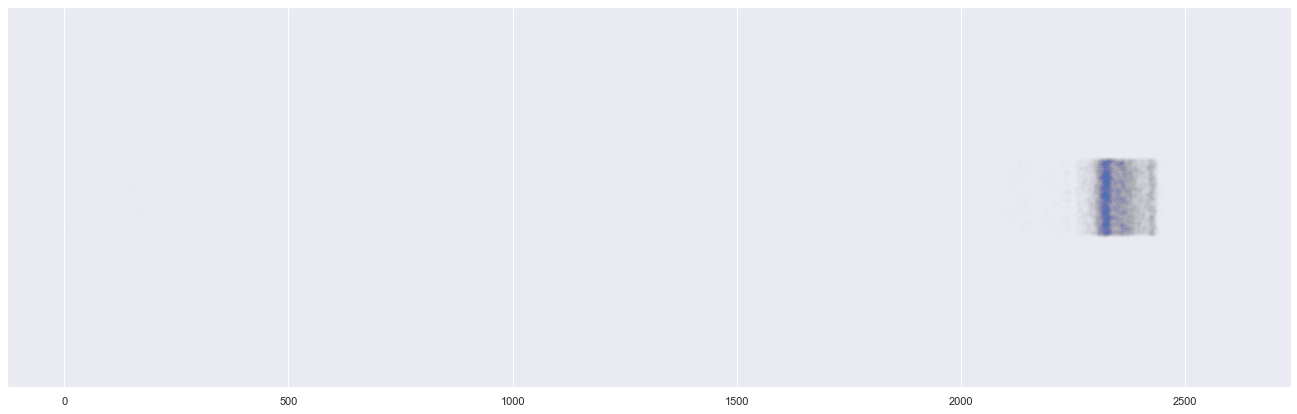

In [13]:
sns.set(rc={"figure.figsize": (23, 7)})

keys = list(test.keys())
# participants progress bar
keys_pbar = tqdm(
    iterable=keys,
    total=len(keys),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for k in keys_pbar:
    sns.stripplot(x=test[k], alpha=0.005)
plt.show()

In [14]:
def gazes_vs_saccades(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    h_events = h_events[h_events.group != "Sky"]
    total = h_events.index.size

    rest = h_events[h_events["type"] == "rest"]
    gazes = h_events[h_events["type"] == "gaze"]

    total_r = rest.index.size
    total_g = gazes.index.size
    rest_len = rest["length"].sum()
    gaze_len = gazes["length"].sum()
    total_len = rest_len + gaze_len

    hev_cnts[uid]["rest_cnt"] = total_r
    hev_cnts[uid]["gaze_cnt"] = total_g
    hev_cnts[uid]["rest_avg"] = rest["length"].mean()
    hev_cnts[uid]["gaze_avg"] = gazes["length"].mean()
    hev_cnts[uid]["rest_mdn"] = rest["length"].median()
    hev_cnts[uid]["gaze_mdn"] = gazes["length"].median()
    hev_cnts[uid]["rest_dist_avg"] = rest["distance"].mean()
    hev_cnts[uid]["gaze_dist_avg"] = gazes["distance"].mean()
    hev_cnts[uid]["rest_dist_mdn"] = rest["distance"].median()
    hev_cnts[uid]["gaze_dist_mdn"] = gazes["distance"].median()
    hev_cnts[uid]["rest_len"] = rest_len
    hev_cnts[uid]["gaze_len"] = gaze_len
    hev_cnts[uid]["rest_l_%"] = rest_len * 100 / total_len
    hev_cnts[uid]["gaze_l_%"] = gaze_len * 100 / total_len
    hev_cnts[uid]["rest_c_%"] = total_r * 100 / total
    hev_cnts[uid]["gaze_c_%"] = total_g * 100 / total

    grps = gazes.group.unique()
    for grp in grps:
        sel = gazes[gazes.group == grp]
        g_len = sel["length"].sum()
        g_cnt = sel.index.size
        grp_lpercs[uid][grp] = g_len * 100 / gaze_len
        grp_cpercs[uid][grp] = g_cnt * 100 / total_g
        grp_len[uid][grp] = g_len
        grp_cnt[uid][grp] = g_cnt
    for grp in grp_cats:
        if not grp_lpercs[uid][grp]:
            grp_lpercs[uid][grp] = 0
            grp_cpercs[uid][grp] = 0
            grp_len[uid][grp] = 0
            grp_cnt[uid][grp] = 0


# participants ids
uids = parts.index.tolist()

cats = [
    "rest_cnt",
    "gaze_cnt",
    "rest_avg",
    "gaze_avg",
    "rest_mdn",
    "gaze_mdn",
    "rest_dist_avg",
    "gaze_dist_avg",
    "rest_dist_mdn",
    "gaze_dist_mdn",
    "rest_len",
    "gaze_len",
    "rest_l_%",
    "gaze_l_%",
    "rest_c_%",
    "gaze_c_%",
]
stats = {cat: None for cat in cats}

grp_cats = [
    "Buildings",
    # "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]
grp_stats = {cat: None for cat in grp_cats}

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_cnts = manager.dict({uid: manager.dict(stats) for uid in uids})
grp_lpercs = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_cpercs = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_len = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_cnt = manager.dict({uid: manager.dict(grp_stats) for uid in uids})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=gazes_vs_saccades, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# parse and store collected data
hev_cnts = dict(hev_cnts)
hev_cnts = {k: dict(v) for k, v in hev_cnts.items()}
hev_cnts = pd.DataFrame(hev_cnts).transpose()
hev_cnts.to_csv("./hit_events_counters.csv")
display(hev_cnts)

grp_lpercs = dict(grp_lpercs)
grp_cpercs = dict(grp_cpercs)
grp_len = dict(grp_len)
grp_cnt = dict(grp_cnt)
grp_lpercs = {k: dict(v) for k, v in grp_lpercs.items()}
grp_cpercs = {k: dict(v) for k, v in grp_cpercs.items()}
grp_len = {k: dict(v) for k, v in grp_len.items()}
grp_cnt = {k: dict(v) for k, v in grp_cnt.items()}
grp_lpercs = pd.DataFrame(grp_lpercs).transpose()
grp_cpercs = pd.DataFrame(grp_cpercs).transpose()
grp_len = pd.DataFrame(grp_len).transpose()
grp_cnt = pd.DataFrame(grp_cnt).transpose()
grp_lpercs.to_csv("./group_length_percentages.csv")
grp_cpercs.to_csv("./group_counts_percentages.csv")
grp_len.to_csv("./group_lengths.csv")
grp_cnt.to_csv("./group_counts.csv")
display(grp_lpercs)
display(grp_cpercs)
display(grp_len)
display(grp_cnt)

📄 0 of 24356 📂 participants processed:                                                                        …

,rest_cnt,gaze_cnt,rest_avg,gaze_avg,rest_mdn,gaze_mdn,rest_dist_avg,gaze_dist_avg,rest_dist_mdn,gaze_dist_mdn,rest_len,gaze_len,rest_l_%,gaze_l_%,rest_c_%,gaze_c_%
4f583872ffed48249874b00f3d389cfc,426.000,71.000,0.066,0.838,0.033,0.495,104.251,96.410,85.109,58.560,27.918,59.466,31.949,68.051,85.714,14.286
33d68ad55ef544fab9fd08108e3913ca,276.000,80.000,0.084,0.811,0.066,0.611,20.624,9.279,2.375,2.369,23.265,64.878,26.395,73.605,77.528,22.472
8598a83e2af441b8bcd0ae5d84beb875,110.000,37.000,0.089,1.336,0.066,0.660,95.246,148.664,47.726,92.824,9.834,49.434,16.592,83.408,74.830,25.170
37d7e67934974217830bb429bba7fd76,600.000,70.000,0.059,0.745,0.033,0.396,120.848,100.902,82.070,60.092,35.607,52.173,40.564,59.436,89.552,10.448
42bac596059749b5b8e8e83ae61de9b4,335.000,71.000,0.073,0.762,0.066,0.462,165.124,158.016,104.566,96.934,24.519,54.087,31.192,68.808,82.512,17.488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,195.000,67.000,0.079,0.789,0.066,0.462,156.696,120.771,74.949,73.856,15.444,52.866,22.609,77.391,74.427,25.573
611d35a7c3e940cc82495e53c2a8532d,368.000,60.000,0.068,1.047,0.033,0.643,108.500,69.017,73.025,45.928,25.179,62.799,28.620,71.380,85.981,14.019
3b6fda285d9e412eb081986b2f22a2e3,457.000,86.000,0.067,0.662,0.033,0.495,77.104,41.266,38.325,15.416,30.558,56.925,34.930,65.070,84.162,15.838
18ffb0abdc8642098c479380bfa533d1,535.000,77.000,0.068,0.595,0.033,0.429,119.937,89.042,67.788,44.540,36.630,45.804,44.436,55.564,87.418,12.582


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,30.966,2.053,2.719,3.163,6.049,30.244,0.000,0.000,2.386,22.420,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.916,0.509,44.201,0.458,46.236,0.000,0.000,0.560,7.121,0.000
8598a83e2af441b8bcd0ae5d84beb875,77.503,0.000,0.000,1.268,1.869,0.000,0.000,0.000,0.734,18.625,0.000
37d7e67934974217830bb429bba7fd76,32.701,4.175,1.392,9.045,9.677,2.530,0.633,0.000,3.858,35.990,0.000
42bac596059749b5b8e8e83ae61de9b4,63.758,0.000,0.000,0.976,11.836,0.000,0.000,0.000,4.271,19.158,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.419,0.000,0.000,12.172,5.181,0.000,0.000,0.000,1.935,16.292,0.000
611d35a7c3e940cc82495e53c2a8532d,31.266,0.420,0.420,38.728,7.777,4.519,0.000,0.000,1.682,14.609,0.578
3b6fda285d9e412eb081986b2f22a2e3,13.681,0.000,1.275,32.290,1.159,29.391,0.000,1.971,10.203,10.029,0.000
18ffb0abdc8642098c479380bfa533d1,32.925,0.000,0.000,11.960,10.879,14.697,0.000,0.000,3.242,24.928,1.369


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,32.394,4.225,2.817,4.225,11.268,28.169,0.000,0.000,7.042,9.859,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,2.500,1.250,52.500,1.250,38.750,0.000,0.000,1.250,2.500,0.000
8598a83e2af441b8bcd0ae5d84beb875,64.865,0.000,0.000,5.405,8.108,0.000,0.000,0.000,2.703,18.919,0.000
37d7e67934974217830bb429bba7fd76,38.571,2.857,2.857,14.286,15.714,5.714,1.429,0.000,8.571,10.000,0.000
42bac596059749b5b8e8e83ae61de9b4,57.746,0.000,0.000,2.817,19.718,0.000,0.000,0.000,7.042,12.676,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,62.687,0.000,0.000,13.433,8.955,0.000,0.000,0.000,2.985,11.940,0.000
611d35a7c3e940cc82495e53c2a8532d,35.000,1.667,1.667,30.000,13.333,6.667,0.000,0.000,5.000,5.000,1.667
3b6fda285d9e412eb081986b2f22a2e3,11.628,0.000,2.326,30.233,2.326,33.721,0.000,2.326,10.465,6.977,0.000
18ffb0abdc8642098c479380bfa533d1,32.468,0.000,0.000,16.883,15.584,12.987,0.000,0.000,5.195,14.286,2.597


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,1.221,1.617,1.881,3.597,17.985,0.000,0.000,1.419,13.332,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.330,28.677,0.297,29.997,0.000,0.000,0.363,4.620,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000
37d7e67934974217830bb429bba7fd76,17.061,2.178,0.726,4.719,5.049,1.320,0.330,0.000,2.013,18.777,0.000
42bac596059749b5b8e8e83ae61de9b4,34.485,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.613,0.000
611d35a7c3e940cc82495e53c2a8532d,19.635,0.264,0.264,24.321,4.884,2.838,0.000,0.000,1.056,9.174,0.363
3b6fda285d9e412eb081986b2f22a2e3,7.788,0.000,0.726,18.381,0.660,16.731,0.000,1.122,5.808,5.709,0.000
18ffb0abdc8642098c479380bfa533d1,15.081,0.000,0.000,5.478,4.983,6.732,0.000,0.000,1.485,11.418,0.627


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,23,3,2,3,8,20,0,0,5,7,0
33d68ad55ef544fab9fd08108e3913ca,0,2,1,42,1,31,0,0,1,2,0
8598a83e2af441b8bcd0ae5d84beb875,24,0,0,2,3,0,0,0,1,7,0
37d7e67934974217830bb429bba7fd76,27,2,2,10,11,4,1,0,6,7,0
42bac596059749b5b8e8e83ae61de9b4,41,0,0,2,14,0,0,0,5,9,0
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,42,0,0,9,6,0,0,0,2,8,0
611d35a7c3e940cc82495e53c2a8532d,21,1,1,18,8,4,0,0,3,3,1
3b6fda285d9e412eb081986b2f22a2e3,10,0,2,26,2,29,0,2,9,6,0
18ffb0abdc8642098c479380bfa533d1,25,0,0,13,12,10,0,0,4,11,2


In [15]:
display(hev_cnts.describe())

,rest_cnt,gaze_cnt,rest_avg,gaze_avg,rest_mdn,gaze_mdn,rest_dist_avg,gaze_dist_avg,rest_dist_mdn,gaze_dist_mdn,rest_len,gaze_len,rest_l_%,gaze_l_%,rest_c_%,gaze_c_%
count,24356.000,24356.000,24355.000,24356.000,24355.000,24356.000,24355.000,24356.000,24355.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,359.147,67.524,0.073,0.959,0.049,0.536,77.994,68.443,43.753,35.031,25.443,58.688,30.146,69.854,81.847,18.153
std,156.010,13.243,0.008,0.988,0.017,0.805,44.984,53.694,35.591,36.303,9.700,10.293,11.098,11.098,7.122,7.122
min,0.000,1.000,0.033,0.466,0.033,0.330,0.236,0.267,0.165,0.267,0.000,23.331,0.000,31.021,0.000,4.954
25%,245.750,61.000,0.068,0.703,0.033,0.446,41.464,19.157,7.275,2.470,18.612,51.414,22.505,61.970,78.709,13.265
50%,357.000,69.000,0.072,0.819,0.033,0.495,80.437,59.119,41.281,22.486,25.839,57.915,30.641,69.359,83.432,16.568
75%,467.000,76.000,0.077,1.007,0.066,0.561,110.803,108.091,68.506,61.877,32.348,65.538,38.030,77.495,86.735,21.291
max,968.000,103.000,0.132,88.143,0.132,88.143,229.507,259.045,207.666,193.290,60.390,88.143,68.979,100.000,95.046,100.000


In [16]:
hit_levs = pd.read_csv(f"./group_length_percentages.csv", index_col=0)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,30.966,2.053,2.719,3.163,6.049,30.244,0.000,0.000,2.386,22.420,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.916,0.509,44.201,0.458,46.236,0.000,0.000,0.560,7.121,0.000
8598a83e2af441b8bcd0ae5d84beb875,77.503,0.000,0.000,1.268,1.869,0.000,0.000,0.000,0.734,18.625,0.000
37d7e67934974217830bb429bba7fd76,32.701,4.175,1.392,9.045,9.677,2.530,0.633,0.000,3.858,35.990,0.000
42bac596059749b5b8e8e83ae61de9b4,63.758,0.000,0.000,0.976,11.836,0.000,0.000,0.000,4.271,19.158,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.419,0.000,0.000,12.172,5.181,0.000,0.000,0.000,1.935,16.292,0.000
611d35a7c3e940cc82495e53c2a8532d,31.266,0.420,0.420,38.728,7.777,4.519,0.000,0.000,1.682,14.609,0.578
3b6fda285d9e412eb081986b2f22a2e3,13.681,0.000,1.275,32.290,1.159,29.391,0.000,1.971,10.203,10.029,0.000
18ffb0abdc8642098c479380bfa533d1,32.925,0.000,0.000,11.960,10.879,14.697,0.000,0.000,3.242,24.928,1.369


In [17]:
hit_cevs = pd.read_csv(f"./group_counts_percentages.csv", index_col=0)
hit_cevs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,32.394,4.225,2.817,4.225,11.268,28.169,0.000,0.000,7.042,9.859,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,2.500,1.250,52.500,1.250,38.750,0.000,0.000,1.250,2.500,0.000
8598a83e2af441b8bcd0ae5d84beb875,64.865,0.000,0.000,5.405,8.108,0.000,0.000,0.000,2.703,18.919,0.000
37d7e67934974217830bb429bba7fd76,38.571,2.857,2.857,14.286,15.714,5.714,1.429,0.000,8.571,10.000,0.000
42bac596059749b5b8e8e83ae61de9b4,57.746,0.000,0.000,2.817,19.718,0.000,0.000,0.000,7.042,12.676,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,62.687,0.000,0.000,13.433,8.955,0.000,0.000,0.000,2.985,11.940,0.000
611d35a7c3e940cc82495e53c2a8532d,35.000,1.667,1.667,30.000,13.333,6.667,0.000,0.000,5.000,5.000,1.667
3b6fda285d9e412eb081986b2f22a2e3,11.628,0.000,2.326,30.233,2.326,33.721,0.000,2.326,10.465,6.977,0.000
18ffb0abdc8642098c479380bfa533d1,32.468,0.000,0.000,16.883,15.584,12.987,0.000,0.000,5.195,14.286,2.597


In [18]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,30.966,2.053,2.719,3.163,6.049,30.244,0.000,0.000,2.386,22.420,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.916,0.509,44.201,0.458,46.236,0.000,0.000,0.560,7.121,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,77.503,0.000,0.000,1.268,1.869,0.000,0.000,0.000,0.734,18.625,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,32.701,4.175,1.392,9.045,9.677,2.530,0.633,0.000,3.858,35.990,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,63.758,0.000,0.000,0.976,11.836,0.000,0.000,0.000,4.271,19.158,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.419,0.000,0.000,12.172,5.181,0.000,0.000,0.000,1.935,16.292,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,31.266,0.420,0.420,38.728,7.777,4.519,0.000,0.000,1.682,14.609,0.578,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,13.681,0.000,1.275,32.290,1.159,29.391,0.000,1.971,10.203,10.029,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,32.925,0.000,0.000,11.960,10.879,14.697,0.000,0.000,3.242,24.928,1.369,BMBF,left,RadioTalk,Yes


In [19]:
hit_cevs = hit_cevs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_cevs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,32.394,4.225,2.817,4.225,11.268,28.169,0.000,0.000,7.042,9.859,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,2.500,1.250,52.500,1.250,38.750,0.000,0.000,1.250,2.500,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,64.865,0.000,0.000,5.405,8.108,0.000,0.000,0.000,2.703,18.919,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,38.571,2.857,2.857,14.286,15.714,5.714,1.429,0.000,8.571,10.000,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,57.746,0.000,0.000,2.817,19.718,0.000,0.000,0.000,7.042,12.676,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,62.687,0.000,0.000,13.433,8.955,0.000,0.000,0.000,2.985,11.940,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,35.000,1.667,1.667,30.000,13.333,6.667,0.000,0.000,5.000,5.000,1.667,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,11.628,0.000,2.326,30.233,2.326,33.721,0.000,2.326,10.465,6.977,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,32.468,0.000,0.000,16.883,15.584,12.987,0.000,0.000,5.195,14.286,2.597,BMBF,left,RadioTalk,Yes


In [20]:
display(hit_levs.describe())
display(hit_cevs.describe())

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.588,0.773,0.489,33.438,4.703,17.773,0.052,0.056,2.092,12.742,0.294
std,23.125,1.463,0.941,26.091,4.731,18.461,0.259,0.308,2.315,6.487,0.927
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.606,0.000,0.000,10.497,0.602,3.226,0.000,0.000,0.000,7.139,0.000
50%,24.332,0.000,0.000,27.522,3.385,12.276,0.000,0.000,1.408,12.170,0.000
75%,47.713,0.975,0.658,54.287,7.553,26.243,0.000,0.000,3.205,17.319,0.000
max,84.044,15.667,17.852,100.000,32.171,100.000,5.739,8.537,28.382,40.714,13.291


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.562,1.074,0.960,33.862,7.494,17.283,0.097,0.093,3.659,7.385,0.533
std,20.866,1.725,1.552,23.272,6.679,15.280,0.424,0.416,3.735,4.084,1.526
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.407,0.000,0.000,14.035,1.429,4.348,0.000,0.000,0.000,4.054,0.000
50%,26.087,0.000,0.000,30.248,6.250,14.103,0.000,0.000,2.817,7.143,0.000
75%,45.763,1.515,1.493,52.830,12.069,26.667,0.000,0.000,5.495,10.169,0.000
max,84.375,14.815,20.270,100.000,39.080,100.000,7.576,5.882,39.474,35.714,18.182


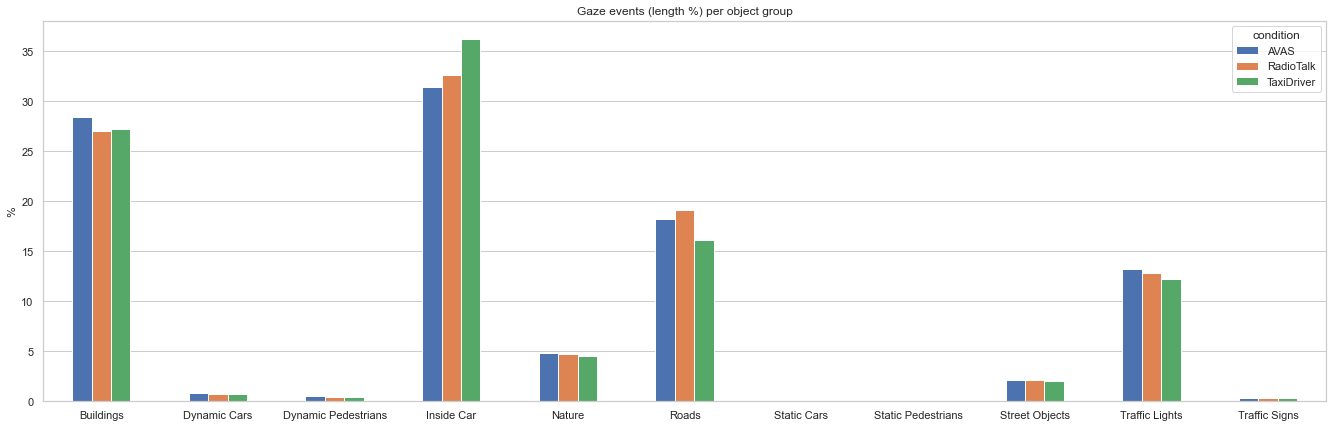

In [21]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_levs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (length %) per object group")

plt.show()

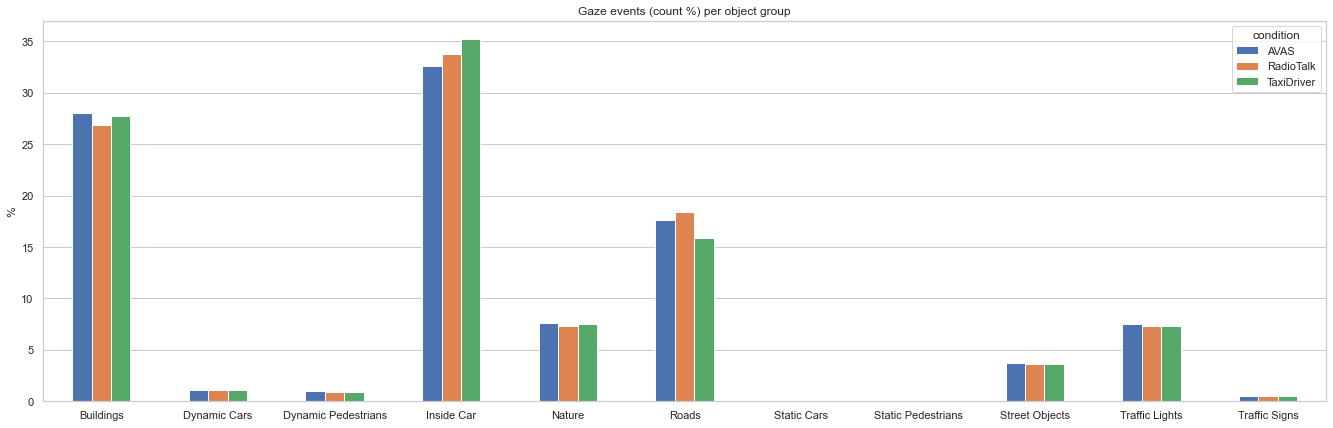

In [22]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_cevs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (count %) per object group")

plt.show()

In [30]:
grp_cats = [
    "Buildings",
    # "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

sns.set_style(STYLE)  # set seaborn plotting style


def normalize_from_condition(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    s = s / s.loc["TaxiDriver"] - 1
    return s.loc[["AVAS", "RadioTalk"]]


def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (s - s.min()) / (s.max() - s.min())

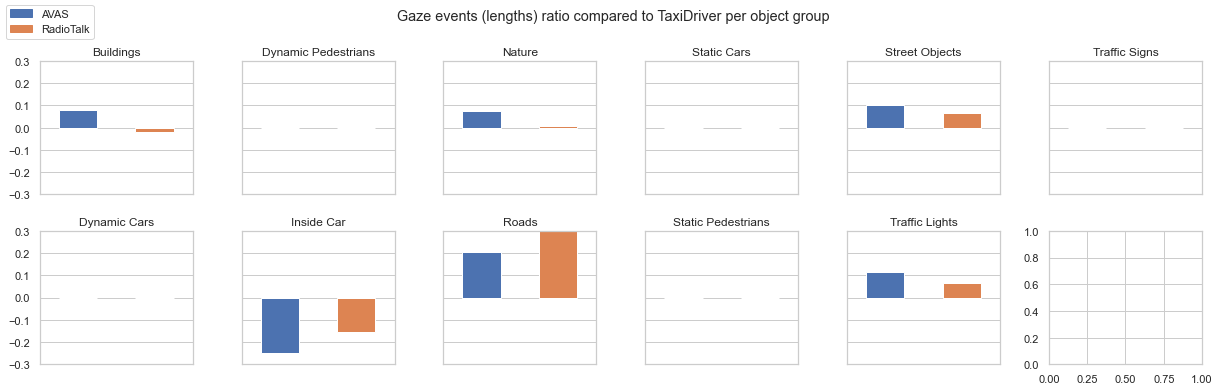

In [38]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

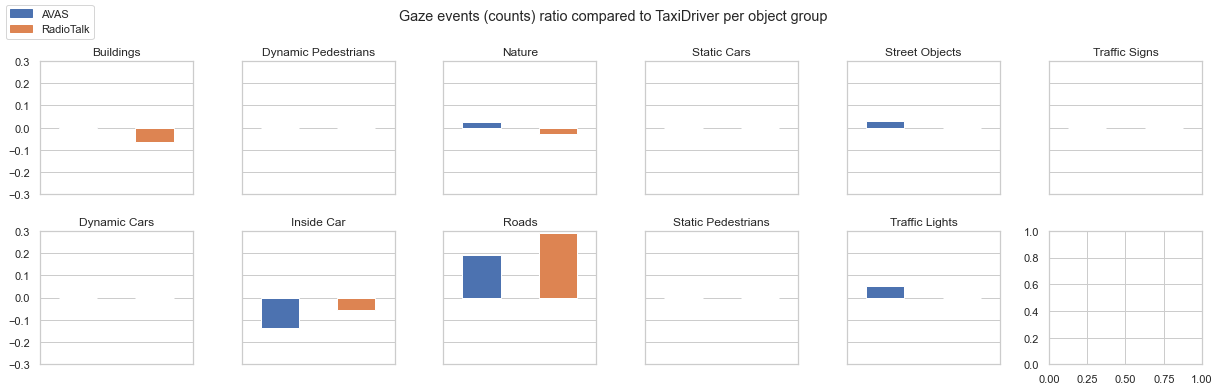

In [40]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

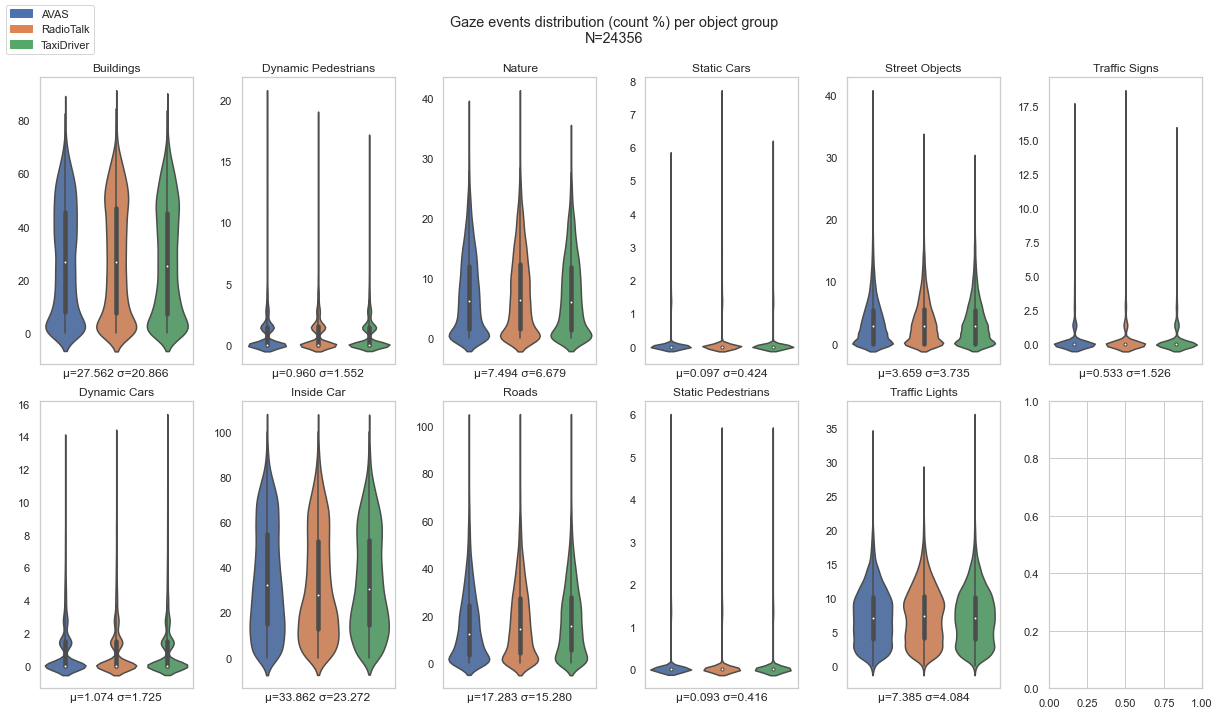

In [41]:
NROWS = 2
NCOLS = 6
N = hit_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_cevs[grp].mean()
            std = hit_cevs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(data=hit_cevs, x="condition", y=grp, ax=axes[r, c])
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

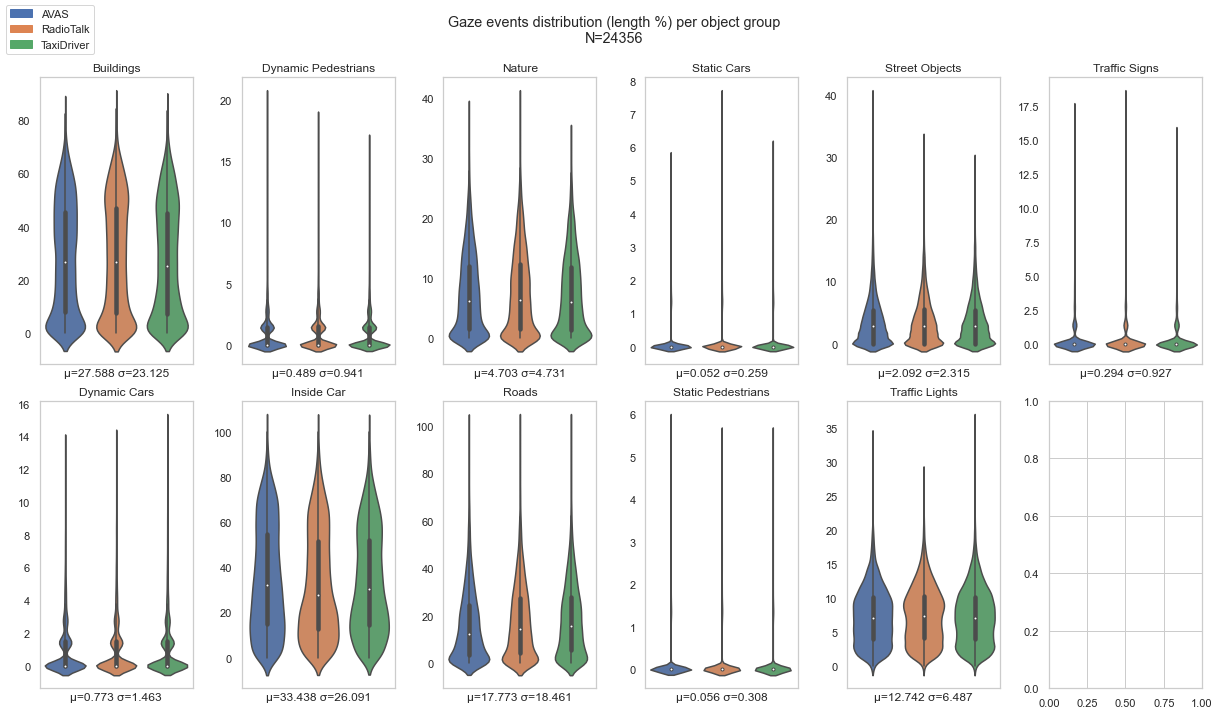

In [42]:
NROWS = 2
NCOLS = 6
N = hit_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_levs[grp].mean()
            std = hit_levs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(data=hit_cevs, x="condition", y=grp, ax=axes[r, c])
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

Final Groups

In [48]:
final_groups = [
    "Buildings",
    "Inside Car",
    "Nature",
    "condition"
]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
gaze_levs["Traffic Signs"] = hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]

# count
gaze_cevs = hit_cevs[final_groups]
gaze_cevs["Cars and Pedestrians"] = hit_cevs["Dynamic Cars"] + hit_cevs["Dynamic Pedestrians"]
gaze_cevs["Roads"] = hit_cevs["Static Cars"] + hit_cevs["Roads"]
gaze_cevs["Street Objects"] = hit_cevs["Street Objects"] + hit_cevs["Static Pedestrians"]
gaze_cevs["Traffic Signs"] = hit_cevs["Traffic Signs"] + hit_cevs["Traffic Lights"]

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = gaze_levs["Cars and Pedestrians"] + gaze_levs["Roads"] + gaze_levs["Traffic Signs"]
gaze_ltr["non-TR"] = gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
gaze_ltr["condition"] = gaze_levs["condition"]
gaze_ctr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ctr["TR"] = gaze_cevs["Cars and Pedestrians"] + gaze_cevs["Roads"] + gaze_cevs["Traffic Signs"]
gaze_ctr["non-TR"] = gaze_cevs["Buildings"] + gaze_cevs["Nature"] + gaze_cevs["Street Objects"]
gaze_ctr["condition"] = gaze_cevs["condition"]

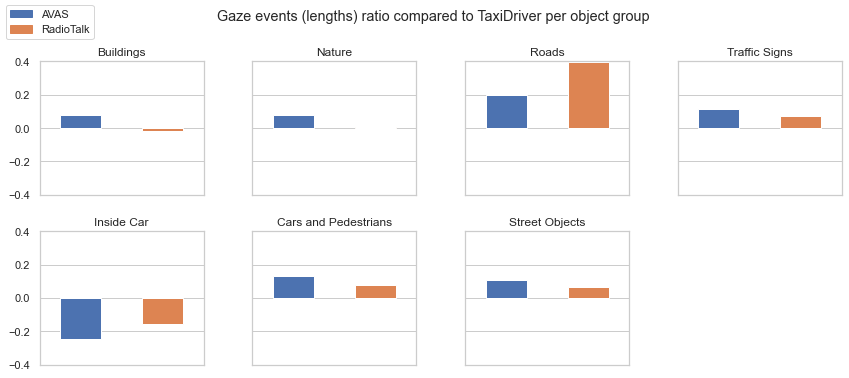

In [69]:
NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

groups = gaze_levs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.4, 0.4)
            ax.set_xticks([])

fig.delaxes(axes[1,3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

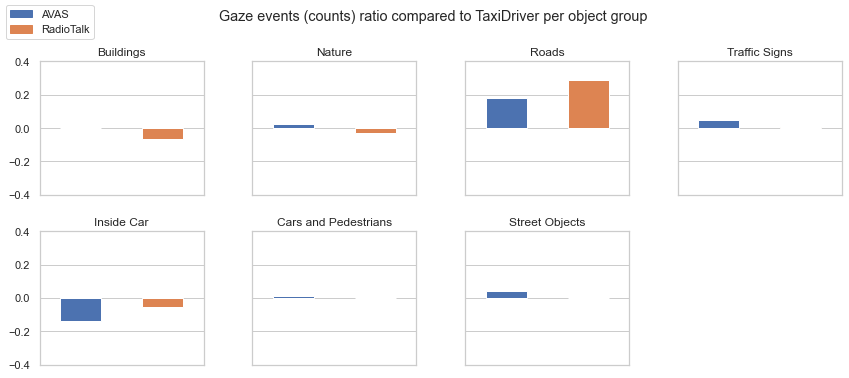

In [65]:
NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

groups = gaze_cevs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.4, 0.4)
            ax.set_xticks([])

fig.delaxes(axes[1,3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

TR vs non-TR

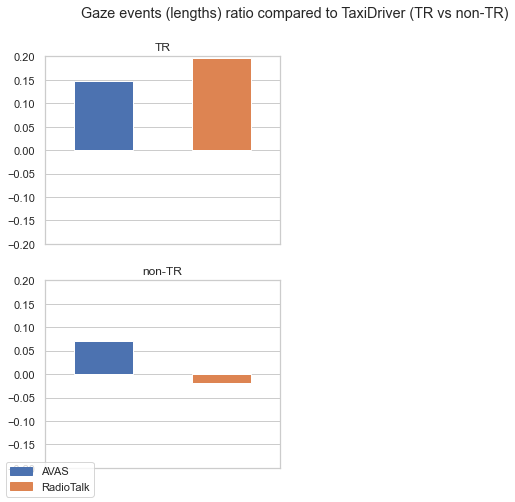

In [90]:
NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ltr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ltr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.2, 0.2)
            ax.set_xticks([])

fig.delaxes(axes[1,1])
fig.delaxes(axes[0,1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()

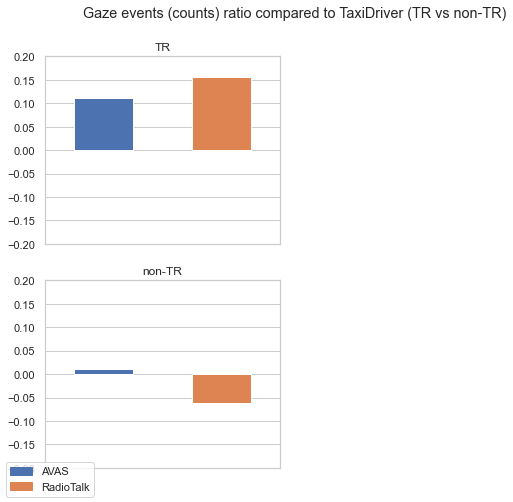

In [91]:
NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ctr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ctr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.2, 0.2)
            ax.set_xticks([])

fig.delaxes(axes[1,1])
fig.delaxes(axes[0,1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()